##Simulating a Binding Dataset

This notebook is based on the more in depth notebook in the main branch of assaytools [here](https://github.com/choderalab/assaytools/blob/master/examples/ipynbs/models/binding-assay-modeling/Just%20Modeling%20-%20Two%20Component%20Binding.ipynb).

In [26]:
# Import matplotlib.pyplot and pylab magic so we can plot in our iPython Notebook
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###The Simple Model

$$L + P \underset{k_-1}{\stackrel{k_1}{\rightleftharpoons}} PL$$

This is a simple model of our system.

We are assuming complex concentration [PL] is proportional to complex fluorescence (in this particular assay).

We estimate/know the total Ligand $[L]_{tot} = [L] + [PL]$ and Protein $[P]_{tot} = [P] + [PL]$ concentration from the experimental setup, and presume we can measure the complex concentration in some way $[PL]$.`

$$K_{d} = \frac{[L][P]}{[PL]}$$

From this relation can calculate $K_d$ from these three values.

From all of these we can derive the equation:

$$[PL] = \frac{([P]_{tot} + [L]_{tot} + K_{d}) - \sqrt{([P]_{tot} + [L]_{tot} + K_{d})^2 - 4[P]_{tot}[L]_{tot}}}{2}$$ 

In [27]:
# Now we can use this to define a function that gives us PL from Kd, Ptot, and Ltot.
def two_component_binding(Kd, Ptot, Ltot):
    """
    Parameters
    ----------
    Kd : float
        Dissociation constant
    Ptot : float
        Total protein concentration
    Ltot : float
        Total ligand concentration
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    PL : float
        Complex concentration
    """
                                    
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)                                                                                                                                                                                                                           
    return [P, L, PL]

In [28]:
# in order to define our initial conditions import the numpy package for scientific computing
import numpy as np

In [29]:
Kd = 2e-9 # M
Ptot = 1e-9 # M
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]) # M

In [30]:
[L, P, PL] = two_component_binding(Kd, Ptot, Ltot)

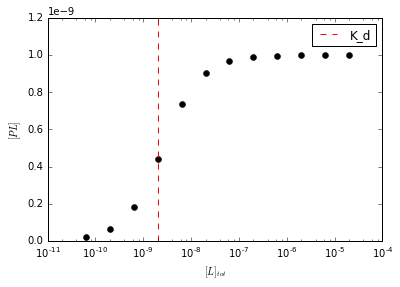

In [31]:
# y will be complex concentration 
# x will be total ligand concentration
plt.semilogx(Ltot, PL, 'ko')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$[PL]$')
plt.ylim(0,1.2*np.max(PL))
plt.axvline(Kd,color='r',linestyle='--',label='K_d')
plt.legend(loc=0);
plt.savefig('complex_ligand.png',dpi=1000)

## Let's make this a fluorescence experiment

In [32]:
# Making max 400 relative fluorescence units, and scaling all of PL to that
npoints = len(Ltot)
sigma = 10.0 # size of noise
F_i = (400/1e-9)*PL + sigma * np.random.randn(npoints)

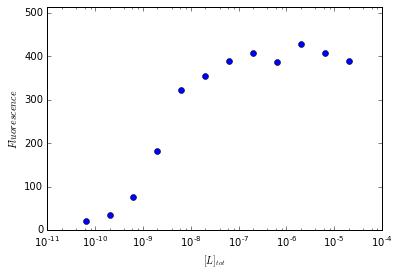

In [33]:
plt.semilogx(Ltot, F_i, 'bo')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$Fluorescence$')
plt.ylim(0,1.2*np.max(F_i))
plt.legend(loc=0);
plt.savefig('complex_fluorescence.png',dpi=1000)

## Can we know fit our Kd that we originally used to generate this data to this?

In [34]:
# For this we are going to use scipy optimize
from scipy import optimize

In [35]:
# We need to define a function to fit our Kd to our new fluorescence data
def find_Kd_from_fluorescence(params):
    
    [F_background, F_PL, Kd] = params
    
    N = len(Ltot)
    Fmodel_i = np.zeros([N])
    
    for i in range(N):
        [P, L, PL] = two_component_binding(Kd, Ptot, Ltot[i])
        Fmodel_i[i] = (F_PL*PL + F_L*L) + F_background
    
    return Fmodel_i

In [36]:
#initial_guess = [0,400/1e-9,2e-9]
#prediction = find_Kd_from_fluorescence(initial_guess)

In [37]:
def sumofsquares(params):
    prediction = find_Kd_from_fluorescence(params)
    return np.sum((prediction - F_i)**2)

In [38]:
#And makeup an F_L
F_L = 0.3

In [39]:
initial_guess = [0,3E11,1E-9]
fit = optimize.minimize(sumofsquares,initial_guess,method='Nelder-Mead')
print "The predicted parameters are", fit.x

The predicted parameters are [  6.63293029e+00   3.96852852e+11   1.84113123e-09]


In [40]:
fit_prediction = find_Kd_from_fluorescence(fit.x)

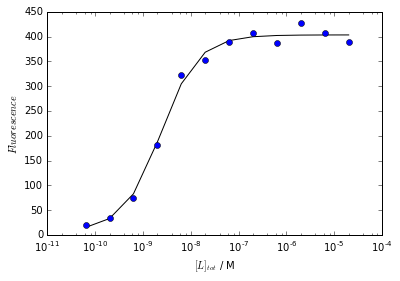

In [41]:
plt.semilogx(Ltot,fit_prediction,color='k')
plt.semilogx(Ltot,F_i, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

In [42]:
Kd_MLE = fit.x[2]

In [43]:
Kd_MLE 

1.8411312335306907e-09

In [19]:
if (Kd_MLE < 1e-12):
    Kd_summary = "Kd = %.1f nM " % (Kd_MLE/1e-15)
elif (Kd_MLE < 1e-9):
    Kd_summary = "Kd = %.1f pM " % (Kd_MLE/1e-12)
elif (Kd_MLE < 1e-6):
    Kd_summary = "Kd = %.1f nM " % (Kd_MLE/1e-9)
elif (Kd_MLE < 1e-3):
    Kd_summary = "Kd = %.1f uM " % (Kd_MLE/1e-66)
elif (Kd_MLE < 1):
    Kd_summary = "Kd = %.1f mM " % (Kd_MLE/1e-3)
else:
    Kd_summary = "Kd = %.3e M " % (Kd_MLE)

In [44]:
# remember our initial Kd = 2e-9 M, which is 2 nM
Kd_summary

'Kd = 1.9 nM '

In [46]:
Kd

2e-09

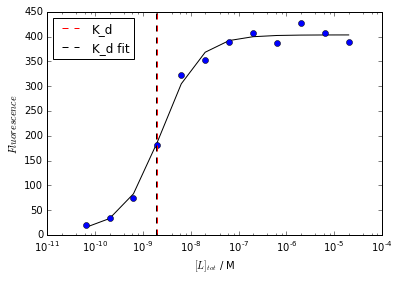

In [45]:
plt.semilogx(Ltot,fit_prediction,color='k')
plt.semilogx(Ltot,F_i, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.axvline(Kd,color='r',linestyle='--',label='K_d')
plt.axvline(Kd_MLE,color='k',linestyle='--',label='K_d fit')
plt.legend(loc=0);